In [9]:
import pandas as pd
import psycopg2
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Connect to PostgreSQL
conn = psycopg2.connect(
    host="localhost",
    database="bank_reviews",
    user="postgres",
    password="backspace"  # replace with your password
)

# Load tables
banks_df = pd.read_sql("SELECT * FROM banks;", conn)
reviews_df = pd.read_sql("SELECT * FROM reviews;", conn)

conn.close()

# Quick check
print(banks_df)
print(reviews_df.head())


   bank_id                    bank_name       app_name
0        1  Commercial Bank of Ethiopia     CBE Mobile
1        2            Bank of Abyssinia     BOA Mobile
2        3                  Dashen Bank  Dashen Mobile
   review_id  bank_id                            review_text  rating  \
0          1        1  Love the app but it crashes sometimes       4   
1          6        2            Good app but slow transfers       3   
2          7        2         Love the new fingerprint login       5   
3          8        3                  App crashes sometimes       2   
4          9        3                 Very fast and reliable       5   

  review_date sentiment_label  sentiment_score       source  
0  2025-12-01        positive              0.8  Google Play  
1  2025-11-15         neutral              0.2  Google Play  
2  2025-11-20        positive              0.9  Google Play  
3  2025-11-10        negative             -0.8  Google Play  
4  2025-11-18        positive        

/tmp/ipykernel_26815/3223614660.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  banks_df = pd.read_sql("SELECT * FROM banks;", conn)
/tmp/ipykernel_26815/3223614660.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  reviews_df = pd.read_sql("SELECT * FROM reviews;", conn)


In [10]:
# Separate positive and negative reviews
positive_reviews = reviews_df[reviews_df['sentiment_label'] == 'positive']
negative_reviews = reviews_df[reviews_df['sentiment_label'] == 'negative']


In [11]:
def get_top_keywords(df, bank_name, top_n=5):
    bank_id = banks_df[banks_df['bank_name'] == bank_name]['bank_id'].values[0]
    bank_reviews = df[df['bank_id'] == bank_id]['review_text']
    text = " ".join(bank_reviews).lower()
    words = re.findall(r'\b\w+\b', text)
    stopwords = set(["the","and","for","with","but","are","was","this","that","not","very"])  # extend as needed
    keywords = [w for w in words if w not in stopwords and len(w) > 2]
    return Counter(keywords).most_common(top_n)

# Example: Top positive and negative keywords for all banks
for bank_name in banks_df['bank_name']:
    print(f"Bank: {bank_name}")
    print("Top Positive Keywords:", get_top_keywords(positive_reviews, bank_name))
    print("Top Negative Keywords:", get_top_keywords(negative_reviews, bank_name))
    print("-"*50)


Bank: Commercial Bank of Ethiopia
Top Positive Keywords: [('love', 1), ('app', 1), ('crashes', 1), ('sometimes', 1)]
Top Negative Keywords: []
--------------------------------------------------
Bank: Bank of Abyssinia
Top Positive Keywords: [('love', 1), ('new', 1), ('fingerprint', 1), ('login', 1)]
Top Negative Keywords: []
--------------------------------------------------
Bank: Dashen Bank
Top Positive Keywords: [('fast', 1), ('reliable', 1)]
Top Negative Keywords: [('app', 1), ('crashes', 1), ('sometimes', 1)]
--------------------------------------------------


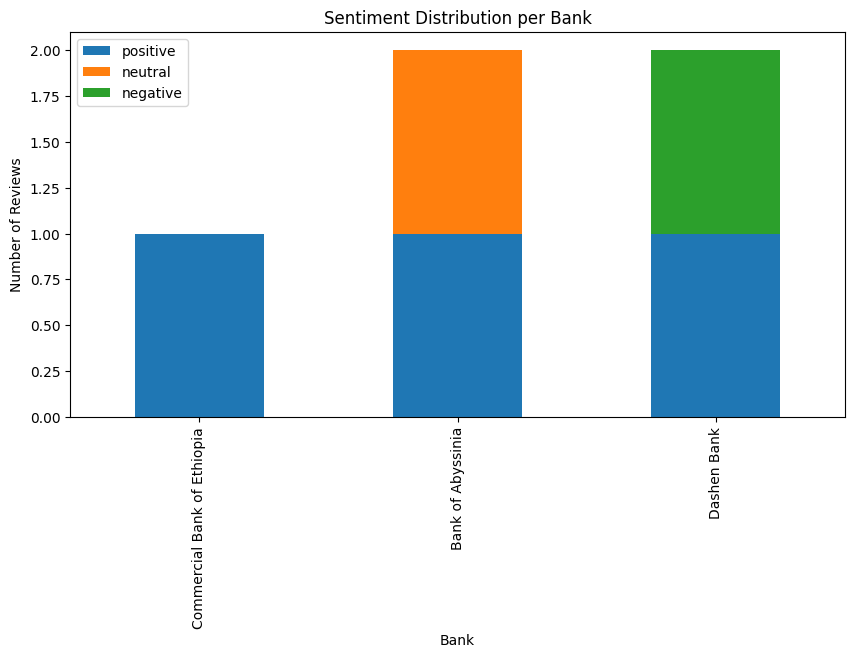

In [12]:
sentiment_counts = reviews_df.groupby(['bank_id','sentiment_label']).size().unstack(fill_value=0)
sentiment_counts = sentiment_counts.merge(banks_df, left_index=True, right_on='bank_id')

# Plot stacked bar chart
sentiment_counts.set_index('bank_name')[['positive','neutral','negative']].plot(
    kind='bar', stacked=True, figsize=(10,5)
)
plt.title("Sentiment Distribution per Bank")
plt.ylabel("Number of Reviews")
plt.xlabel("Bank")
plt.show()


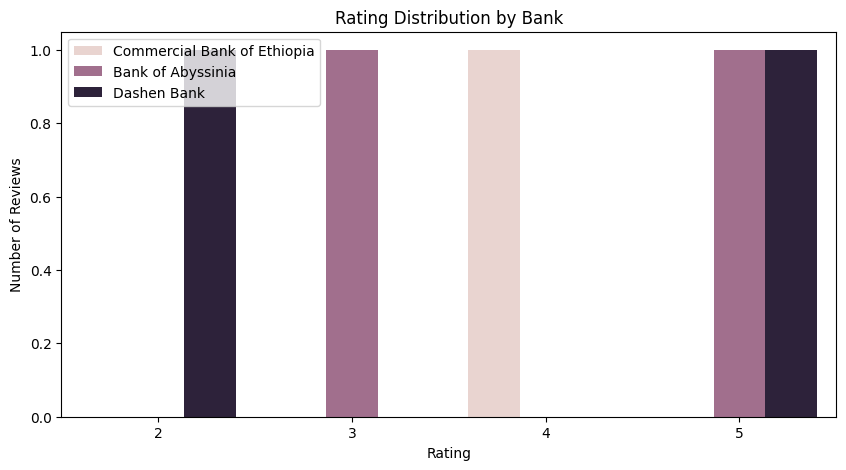

In [6]:
plt.figure(figsize=(10,5))
sns.countplot(x='rating', hue='bank_id', data=reviews_df)
plt.title("Rating Distribution by Bank")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.legend(banks_df.set_index('bank_id')['bank_name'])
plt.show()


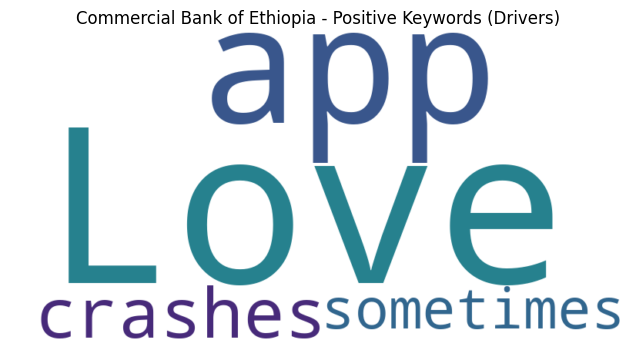

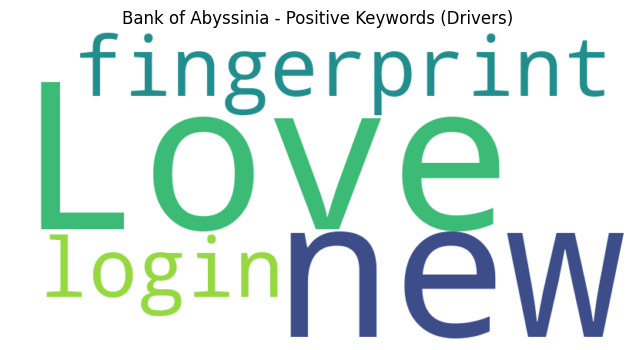

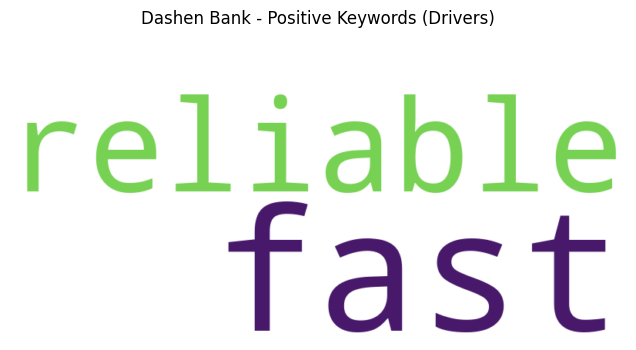

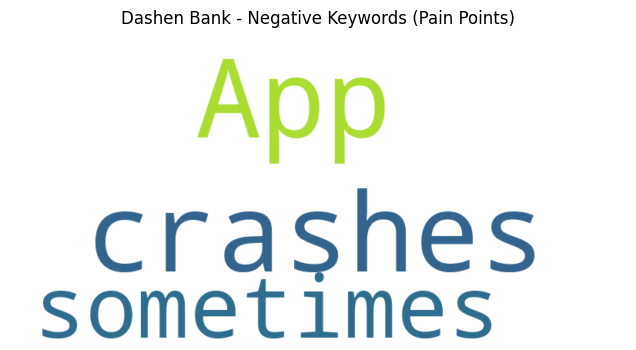

In [8]:
for bank_name in banks_df['bank_name']:
    bank_id = banks_df[banks_df['bank_name'] == bank_name]['bank_id'].values[0]
    
    # Positive keyword cloud (drivers)
    pos_text = " ".join(positive_reviews[positive_reviews['bank_id']==bank_id]['review_text'])
    if pos_text.strip():  # only generate if text is not empty
        wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(pos_text)
        plt.figure(figsize=(10,4))
        plt.imshow(wordcloud_pos, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"{bank_name} - Positive Keywords (Drivers)")
        plt.show()
    
    # Negative keyword cloud (pain points)
    neg_text = " ".join(negative_reviews[negative_reviews['bank_id']==bank_id]['review_text'])
    if neg_text.strip():  # only generate if text is not empty
        wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(neg_text)
        plt.figure(figsize=(10,4))
        plt.imshow(wordcloud_neg, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"{bank_name} - Negative Keywords (Pain Points)")
        plt.show()
